-----Checking for null values for each attribute-----
 Weekday of incident                                      0
Shift                                                    0
Hospital department or location of incident              0
Type of injury incurred, if any                          0
Presence of companion at time of incident                0
Location or environment in which the incident ocurred    0
Fall risk level                                          0
Reason for incident                                      0
Whether a fall prevention protocol was implemented       0
Involvement of medication associated with fall risk      0
Sex                                                      0
Age range                                                0
dtype: int64

-----Printing first 5 samples of the clean datset-----
   Weekday of incident      Shift Hospital department or location of incident  \
0              monday  afternoon                          diagnostic support   
1      

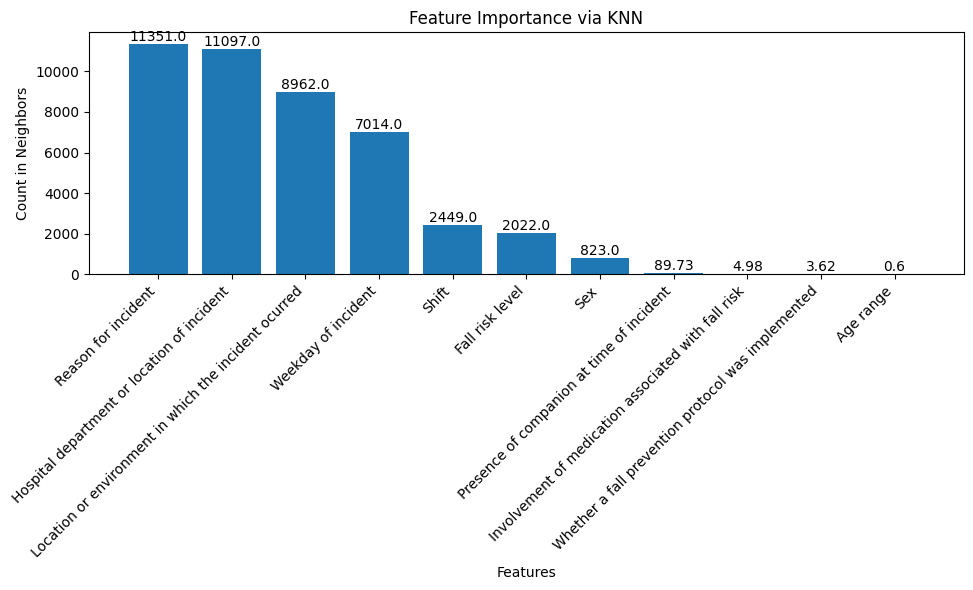

   Injury incurred Predicted Injury incurred
0               no                        no
1               no                       yes
2               no                        no
3              yes                        no
4               no                        no
5               no                        no
6               no                        no
7              yes                        no
8               no                        no
9               no                        no
10             yes                        no
11              no                        no
12             yes                        no
13              no                       yes
14              no                        no
15             yes                        no
16              no                       yes
17              no                        no
18              no                        no
19              no                       yes


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt

# file path here
df = pd.read_csv('C:\\Users\\Alexi\\OneDrive\\Desktop\\Machine Learning\\Project\\FallRiskDataSet.csv')

# Dropped rows with any missing values in any column
df.dropna(inplace=True)

# Dropped columns
df = df.drop(columns=['Number', 'Year', 'Date of incident', 'Severity of incident'])

# get attribute which values that contain '/' or ',' 
contains_slash = df['Presence of companion at time of incident'].str.contains('/')
contains_comma = df['Presence of companion at time of incident'].str.contains(',')

# Standardized 'Presence of companion at the time of incident'
df.loc[contains_slash | contains_comma, 'Presence of companion at time of incident'] = 'yes'

misspelled_mapping = {
    'inpatint units': 'inpatient units',
    'emergency department': 'emergency depart',
    'ob&gyn/birth': 'ob&gynbirth',
    'ob&gyb/birth': 'ob&gynbirth',
    'adult icu': 'adult acu',
    'adult acu': 'adult aci',
    'excotiation': 'excoriation',
    'exam rom': 'exam room',
    'surgical prep adverse event': 'surgical prep aradverse event',
    'deficit motor': 'motor deficit',
    'seious adverse event': 'serious adverse event',
    'female': 'f',
    'male': 'm'
}

# fix inconsistencies
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()
        df[col] = df[col].str.strip()
        for misspelled, correct in misspelled_mapping.items():
            df[col] = df[col].str.replace(misspelled, correct)

# Convert "Age range" column to categories and then codes
df['Age range'] = pd.Categorical(df['Age range of patient'], categories=df['Age range of patient'].unique()).codes

# Dropping original "Age range of patient" column
df.drop(columns=['Age range of patient'], inplace=True)

# Convert all values of attributes with yes and no 
for col in df.columns:
    if df[col].dtype == 'object':
        # (Yes: 1, No: 0)
        if any(df[col].isin(['yes', 'no'])):
            df[col] = df[col].map({'yes': 1, 'no': 0})
        # df[col] = df[col].astype('category').cat.codes
            
    # check values for column are unique (no inconsistencies)
    # print(f'Unique values for Attribute: {col}\n', df[col].unique())
    # print('\n')

# injury occured is new label. mapping 'no injury' to 'no' and any other value to 'yes'
df['Type of injury incurred, if any'] = df['Type of injury incurred, if any'].apply(lambda x: 'no' if x == 'no injury' else 'yes')

# check there are no null values
print('-----Checking for null values for each attribute-----\n', df.isnull().sum())

# debug print for 1st 5 samples
print('\n-----Printing first 5 samples of the clean datset-----\n', df.head())

# send clean data to new csv file
df.to_csv('cleaned_data.csv', index=False)

# Load the cleaned data
df = pd.read_csv('cleaned_data.csv')

# dropping the target variable column
X = df.drop(columns=['Type of injury incurred, if any'])

# Target variable
y = df['Type of injury incurred, if any']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.71, random_state=52)

# This function normalizes a feature (column) of a dataset.
# Normalize a feature (column) of a dataset
def normalize_feature(data, feature):
    # encode sring values
    if data[feature].dtype == 'object':
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    else: # scale values
        scaler = StandardScaler()
        data[feature] = scaler.fit_transform(data[[feature]])
    return data


# Calculates Euclidean distance between two datapoints
def euclidean_distance(dp1, dp2):
    dp1 = np.array(dp1, dtype=float)
    dp2 = np.array(dp2, dtype=float)
    return np.sqrt(np.sum((dp1 - dp2) ** 2))

# Get the k nearest neighbors for a new datapoint (this func modified in jupyter file)
def get_neighbors(X_train, new_dp, k):
    distances = []
    neighbors = [] #erased
    for i, dp in enumerate(X_train):
        dist = euclidean_distance(new_dp, dp)  # cal euclidean distance
        #changed dp for i
        distances.append((dp, dist))           # add point-distance tuple to list
    distances.sort(key=lambda x: x[1])         # sort list on distance
    for i in range(k): #this for was removed
        neighbors.append(distances[i][0])      # add k sorted points from distance list to neighbors list
    return neighbors

# determining the class label for the current datapoint
# based on the majority of class labels of its k neighbors.
def predict_dp(neighbors, y_train): #(this func modified in jupyter file)
    class_counter = Counter()
    for neighbor in neighbors:
        # find corresponding label from y_train for each neighbor
        class_label = y_train[np.where((X_train == neighbor).all(axis=1))[0][0]]
        class_counter[class_label] += 1                 # keep track of Class label counter
    prediction = class_counter.most_common(1)[0][0]     # make pred based on majority class  
    return prediction                       

# Normalizing the features before doing operations
for feature in X.columns:
    X_train = normalize_feature(X_train, feature)
    X_test = normalize_feature(X_test, feature)
    
# predicting the class labels of the test set with k = 3
k = 3
predictions = []
for datapoint in X_test.values:
    neighbors = get_neighbors(X_train.values, datapoint, k)
    prediction = predict_dp(neighbors, y_train.values.ravel())
    predictions.append(prediction)

# Calculating and printing the accuracy of predictions
correct = sum([y_true == y_pred for y_true, y_pred in zip(y_test.values.ravel(), predictions)])
accuracy = (correct / len(y_test)) * 100
print(f"KNN Accuracy: {accuracy:.2f}%")


# #--- KNN plot ---
# Initializing a counter to store feature counts
feature_counts = Counter()

# Loop through each data point in the test set
for datapoint in X_test.values:
    # Initialize a counter for each data point to store feature counts (for plot)
    point_counts = Counter()
    
    # Get indices of the k-nearest neighbors for the current data point within the training set
    neighbors_indices = get_neighbors(X_train.values, datapoint, k)
    # Go through each k-nearest neighbor for the current data point
    for neighbor_index in neighbors_indices:
        # Increment the count for each feature present in the neighbor
        for feature_index, feature_value in enumerate(neighbor_index):
            # Add the value of the current neighbor to the point_counts
            point_counts[X_train.columns[feature_index]] += feature_value
    
    # Update the overall feature_counts with counts from the current neighbor
    feature_counts += point_counts

# rounding neighbor counts to 2 decimal places
rounded_counts = {feature: round(count, 2) for feature, count in feature_counts.items()}

# Sorting features by importance (count)
sorted_features = sorted(rounded_counts.items(), key=lambda x: x[1], reverse=True)

# Extracting features and their counts
features, counts = zip(*sorted_features)

# KNN variable importance plot
plt.figure(figsize=(10, 6))
bars = plt.bar(features, counts)
plt.xlabel('Features')
plt.ylabel('Count in Neighbors')
plt.title('Feature Importance via KNN')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# putting counts as text labels on top of the bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom')

plt.show()



# new DataFrame with original test data and predictions
results_df = pd.DataFrame()
# set the values of actual and predicted fall risk levels to dataframe
results_df['Injury incurred'] = y_test.values.ravel()
results_df['Predicted Injury incurred'] = predictions

# label actual and predictions (20 samples)
print(results_df.head(20))

# Saving the results to a new CSV file
# results_df.to_csv('knn_predictions.csv', index=False)


Random Forest Accuracy: 69.53%
Feature Importance:
                                              Feature  Importance
10  Whether a fall prevention protocol was impleme...    0.190209
0                                           Age range    0.176711
6           Presence of companion at time of incident    0.146751
1                                 Weekday of incident    0.091246
4   Location or environment in which the incident ...    0.080859
2                                 Reason for incident    0.079390
3                                               Shift    0.058906
8                                     Fall risk level    0.053059
5         Hospital department or location of incident    0.052305
9                                                 Sex    0.046451
7   Involvement of medication associated with fall...    0.024114


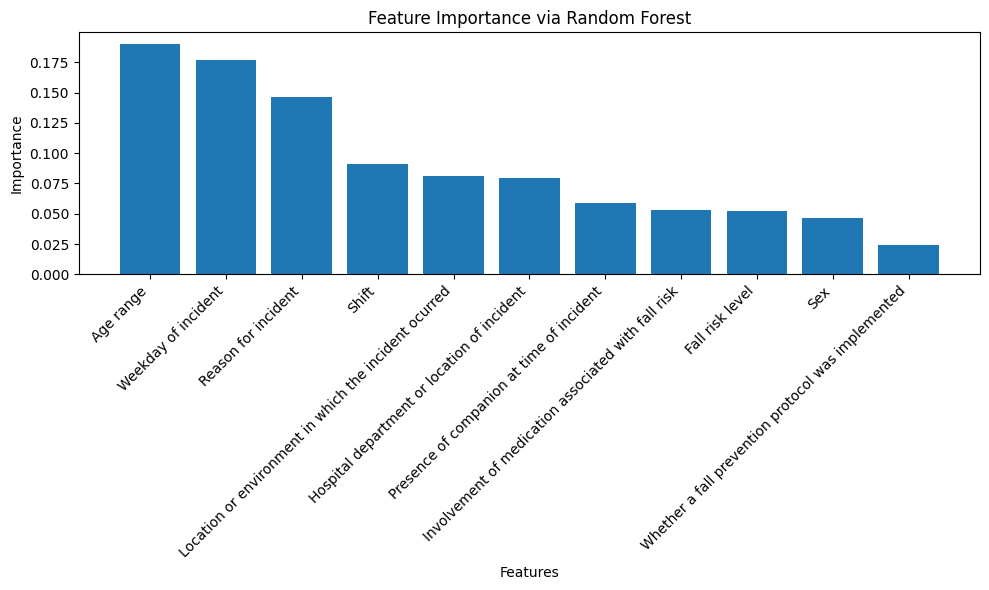

In [9]:
#----Random Forest Model -----
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# create
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=72, class_weight='balanced')

# fit clasifier to data
rf_classifier.fit(X_train, y_train)

# preds on test data
rf_predictions = rf_classifier.predict(X_test)

# accuracy RF
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")

# get feat importances
importances = rf_classifier.feature_importances_

# sort feats importance in descending order
indices = np.argsort(importances)[::-1]

# rearranged feats names based on importance
names = [X.columns[i] for i in indices]

# empty lists for feat names and importances
feature_names = []
importance_values = []

# filling lists with feat names and importances
for name, importance in zip(names, importances):
    feature_names.append(name)
    importance_values.append(importance)

# dataFrame from lists
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})

# Round the importance values to 6 decimal places
feature_importance_df['Importance'] = feature_importance_df['Importance'].round(6)

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print("Feature Importance:")
print(feature_importance_df)


# RF Plot
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), names, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance via Random Forest')
plt.tight_layout()
plt.show()